In [51]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set(style="darkgrid", font_scale=2)


from traces import mongo_wrapper
from traces.filesystem import load_file

In [52]:
def build_task_classes_df(data):
    columns = ['task_class', 'short_name', 'n_tasks', 'avg_duration', 'std_duration', 'max_duration', 'min_duration']
    list_data = []
    count = 0
    for row in data:
        tasks = row['tasks']
        durations = np.array([t['duration'] / (1000000*60*60*24) for t in tasks])
        list_data.append([
            row['name'],
            f't_c_{count}',
            len(tasks),
            durations.mean(),
            durations.std(),
            durations.max(),
            durations.min(),
        ])
        count += 1
    return pd.DataFrame(data=list_data, columns=columns).sort_values(['n_tasks'], ascending=False, ignore_index=True)


def build_dataset_df(data):
    columns = ['index', 'task_class', 'task_id', 'start_day', 'time_start', 'time_end', 
               'duration', 'next_task_start',
               'max_cpus', 'min_cpus', 'max_memory', 'min_memory']
    list_data = []
    scaling_factor = 1000000*60*60*24
    for i, row in enumerate(data):
        if i+1 < len(data):
            next_doc = data[i+1]
            next_task_start = next_doc['time_start'] - row['time_start']
        else:
            next_task_start = 0
        list_data.append([
            row['index'],
            row['name'],
            int(row['name'].split('_')[-1]),
            row['time_start_struct']['days'],
            row['time_start'],
            row['time_end'],
            row['duration'] / scaling_factor,
            next_task_start / scaling_factor,
            row['max_cpus'],
            row['min_cpus'],
            row['max_memory'],
            row['min_memory'],
        ])
    return pd.DataFrame(data=list_data, columns=columns)


def build_grupped_df(df):
    columns = ['task_class', 'task_id', 'mean_duration', 'std_duration', 'min_duration', 'max_duration', 'n_tasks']
    data = []
    counts = df.sort_values(['task_id'], ascending=True).groupby(['task_id'], as_index=False).count().task_class
    means = df.sort_values(['task_id'], ascending=True).groupby(['task_id'], as_index=False).mean().duration
    stds = df.sort_values(['task_id'], ascending=True).groupby(['task_id'], as_index=False).std().duration
    mins = df.sort_values(['task_id'], ascending=True).groupby(['task_id'], as_index=False).min().duration
    maxs = df.sort_values(['task_id'], ascending=True).groupby(['task_id'], as_index=False).max().duration
    for task_id in df.task_id.sort_values().unique():
        data.append([
            f'task_class_{task_id}',
            task_id,
            means[task_id-1],
            stds[task_id-1],
            mins[task_id-1],
            maxs[task_id-1],
            counts[task_id-1]
        ])

    return pd.DataFrame(data=data, columns=columns)


def plot_task_classes(
    data_df, grup_df, task_classes, figsize=(40, 22)
):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    sns.barplot(
        data=data_df.sort_values(['task_id'], ignore_index=True),
        x='duration', y='task_class', palette="Blues_d", ax=axs[0])
    axs[0].set_xlabel('Duration (in days)')
    axs[0].set_ylabel('')
    axs[0].set_title(f'Task classes duration distribution, considering only jobs executed in isolation - {task_classes} task classes')
    axs[0].invert_xaxis()
    axs[0].yaxis.tick_right()

    sns.barplot(data=grup_df, x='n_tasks', y='task_class', palette="Blues_d", ax=axs[1])
    axs[1].set_xlabel('Task instances in the dataset')
    axs[1].set_ylabel('')
    axs[1].set_title(f'Task classes number tasks, considering only jobs executed in isolation - {task_classes} task classes')
    axs[1].set_yticks([])
    fig.tight_layout()
    fig.savefig(f'data/task_classes-info-isolated_jobs-{task_classes}.pdf', bbox_inches='tight', dpi=plt.gcf().dpi)
    
    
def print_load_percentage(df):
    total_tasks = df.n_tasks.sum()
    selected_tasks = df.iloc[0:-1].n_tasks.sum()
    remaining_tasks = df.iloc[-1].n_tasks

    percentage = selected_tasks*100 / total_tasks

    print(f'Total number of tasks: {total_tasks}, we selected: {selected_tasks}, representing: {percentage}% of the total load')


## 50 Task Classes - Isolated Jobs

In [57]:
tasks_dataset_collection_50 = 'tasks_dataset'
dataset_50 = list(mongo_wrapper.db[tasks_dataset_collection_50].find({
    "duration": {"$gt": 1}
}).sort([('time_start', 1)]))

In [58]:
dataset_df_50 = build_dataset_df(dataset_50)
dataset_df_50

,index,task_class,task_id,start_day,time_start,time_end,duration,next_task_start,max_cpus,min_cpus,max_memory,min_memory
0,0,task_class_4,4,0,0,1253120562,0.014504,0.000000e+00,NaN,NaN,NaN,NaN
1,1,task_class_4,4,0,0,7187649934,0.083190,0.000000e+00,NaN,NaN,NaN,NaN
2,2,task_class_5,5,0,0,1253120513,0.014504,0.000000e+00,NaN,NaN,NaN,NaN
3,3,task_class_5,5,0,0,7187649863,0.083190,0.000000e+00,NaN,NaN,NaN,NaN
4,4,task_class_15,15,0,0,74547752874,0.862821,0.000000e+00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13725,13728,task_class_9,9,30,2676755366167,2677901073912,0.013261,5.499314e-03,NaN,NaN,NaN,NaN
13726,13729,task_class_1,1,30,2677230506932,2677890088251,0.007634,2.048611e-09,NaN,NaN,NaN,NaN
13727,13730,task_class_1,1,30,2677230507109,2677838981570,0.007043,9.225571e-05,NaN,NaN,NaN,NaN
13728,13731,task_class_2,2,30,2677238478002,2677543148366,0.003526,4.513889e-10,0.00132,0.00132,0.000685,0.000684


In [59]:
groupped_df_50 = build_grupped_df(dataset_df_50)
groupped_df_50

,task_class,task_id,mean_duration,std_duration,min_duration,max_duration,n_tasks
0,task_class_1,1,0.008066,0.003939,0.005160,0.047337,2978
1,task_class_2,2,0.003275,0.001927,0.001590,0.043350,1476
2,task_class_3,3,0.003402,0.001664,0.001789,0.043683,1296
3,task_class_4,4,0.038760,0.035694,0.006640,0.167964,1238
4,task_class_5,5,0.038759,0.035690,0.006640,0.167964,1238
5,task_class_6,6,0.010850,0.005948,0.005931,0.039747,583
6,task_class_7,7,0.016877,0.003577,0.012908,0.082028,562
7,task_class_8,8,0.010861,0.003824,0.006328,0.082245,558
8,task_class_9,9,0.015275,0.006074,0.012813,0.037866,331
9,task_class_10,10,0.010255,0.006501,0.005183,0.082597,319


Total number of tasks: 13730, we selected: 13095, representing: 95.37509104151493% of the total load


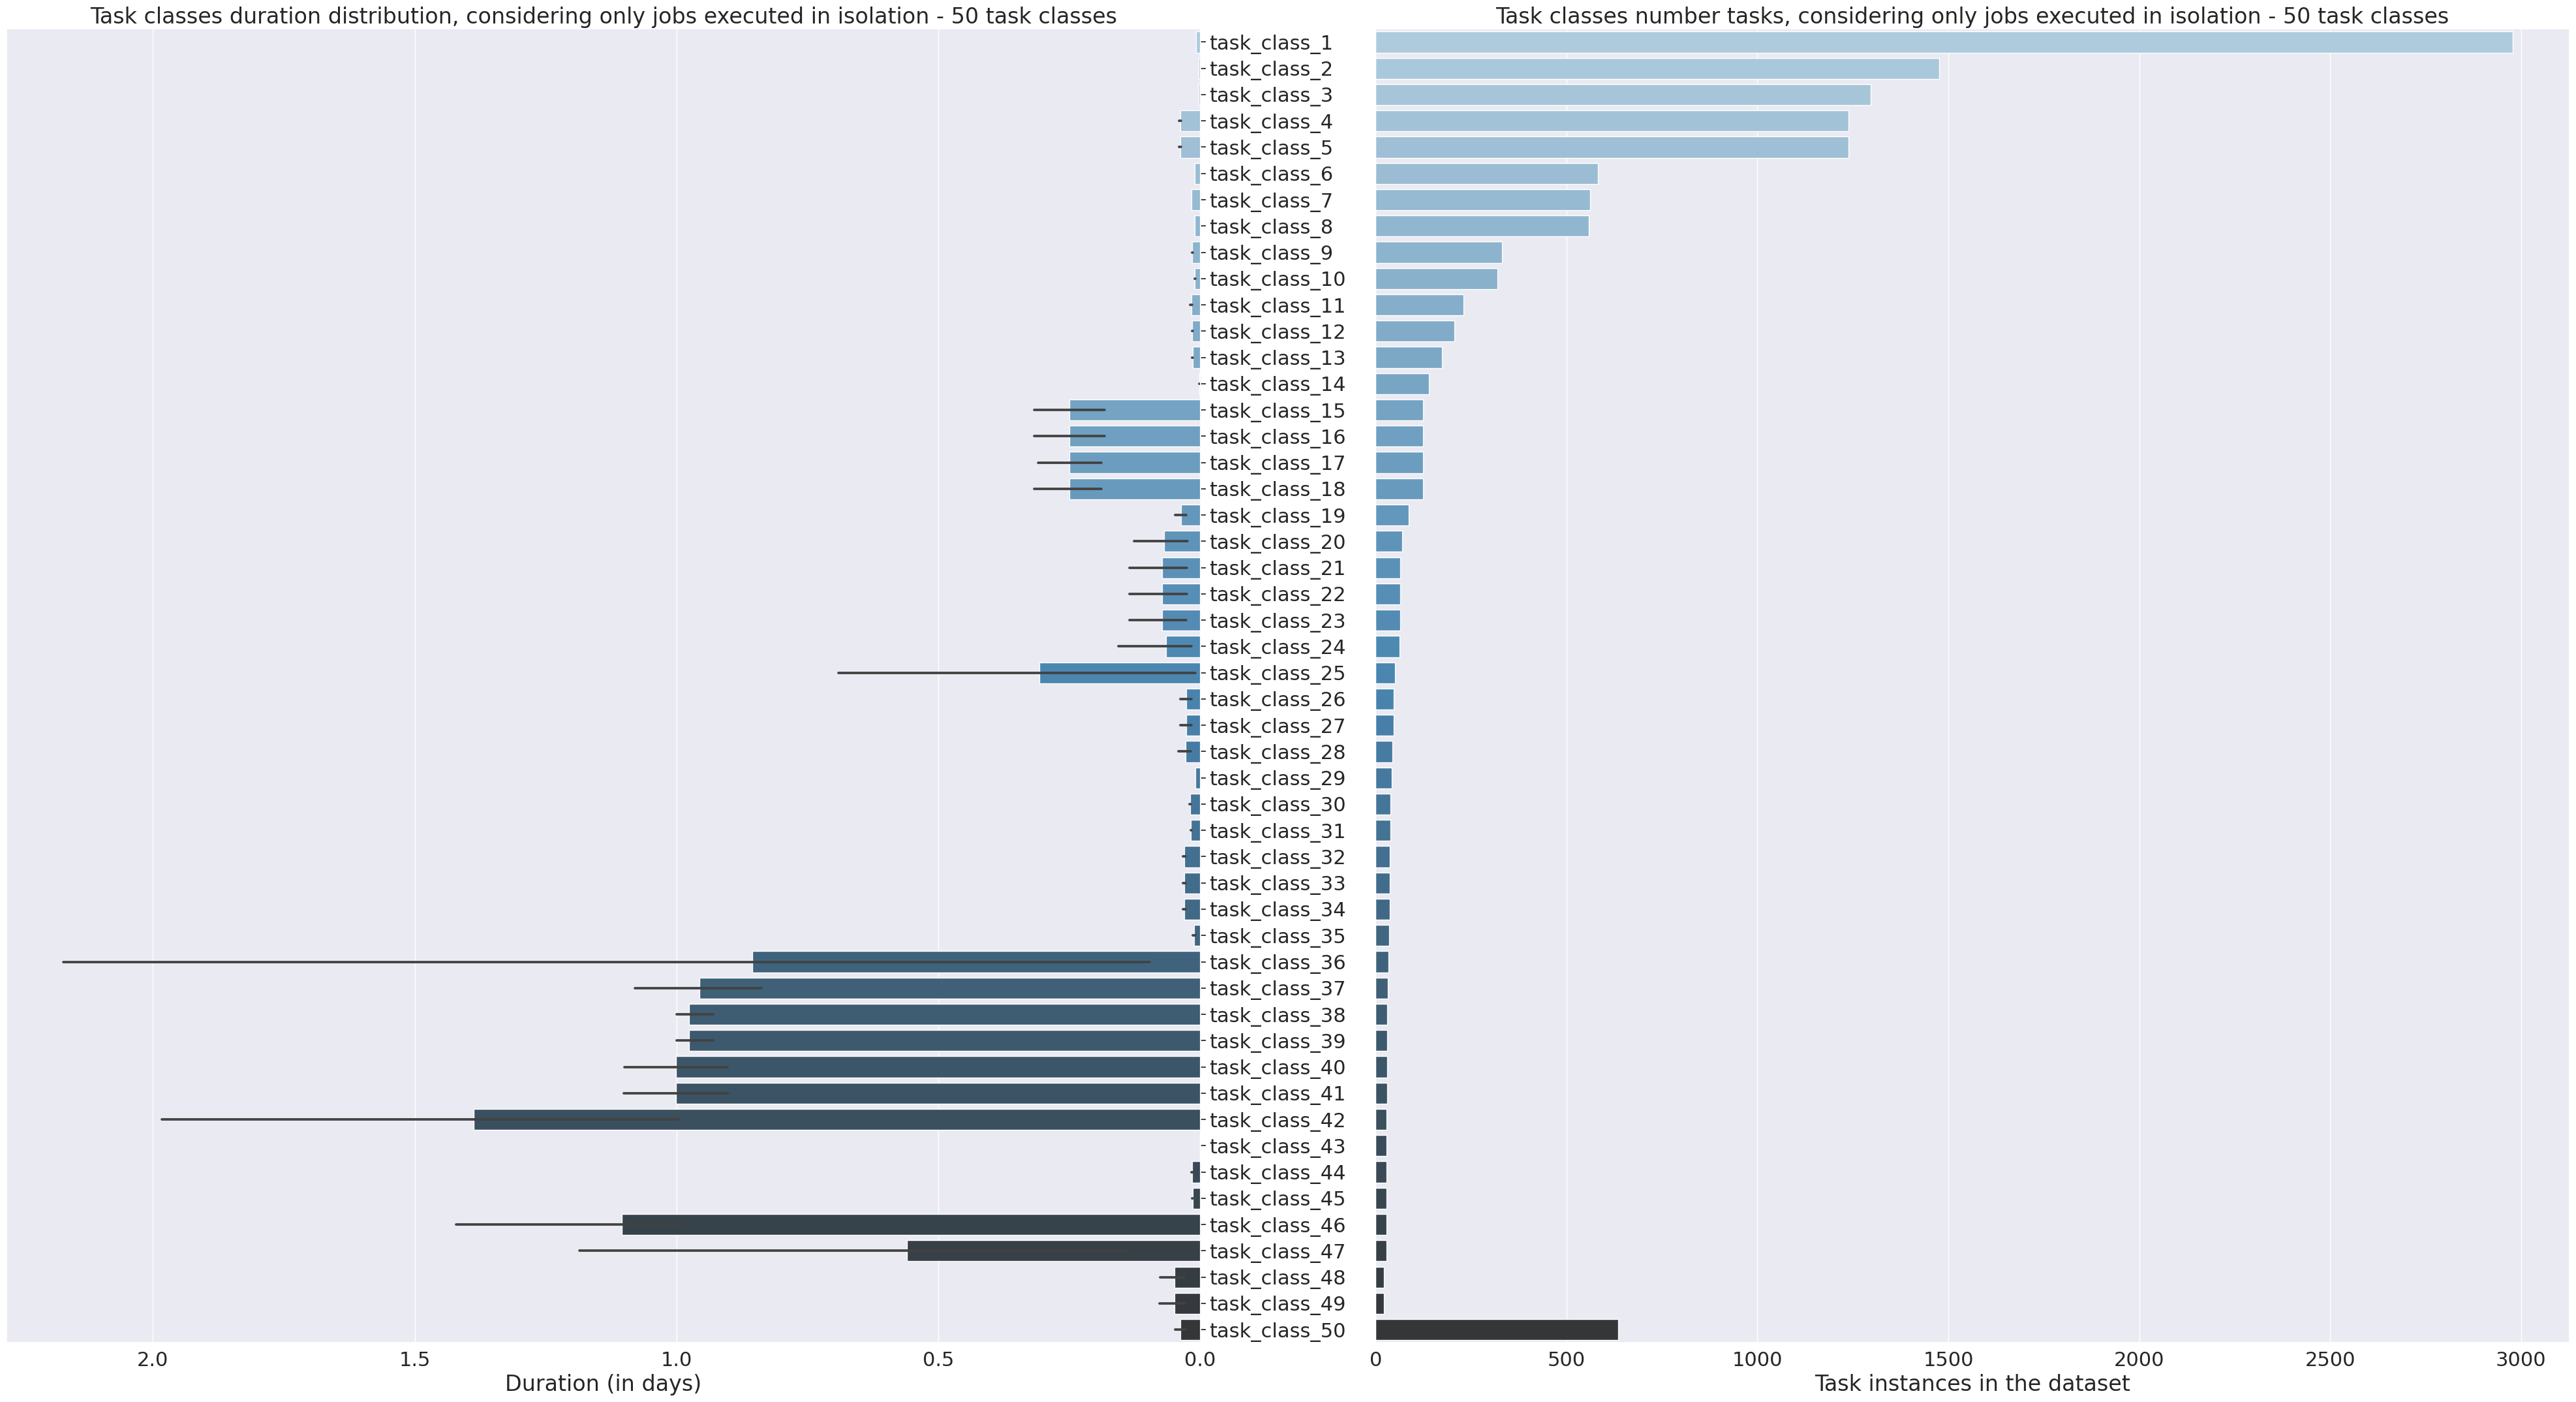

In [76]:
plot_task_classes(dataset_df_50, groupped_df_50, 50, figsize=(40, 22))
print_load_percentage(groupped_df_50)

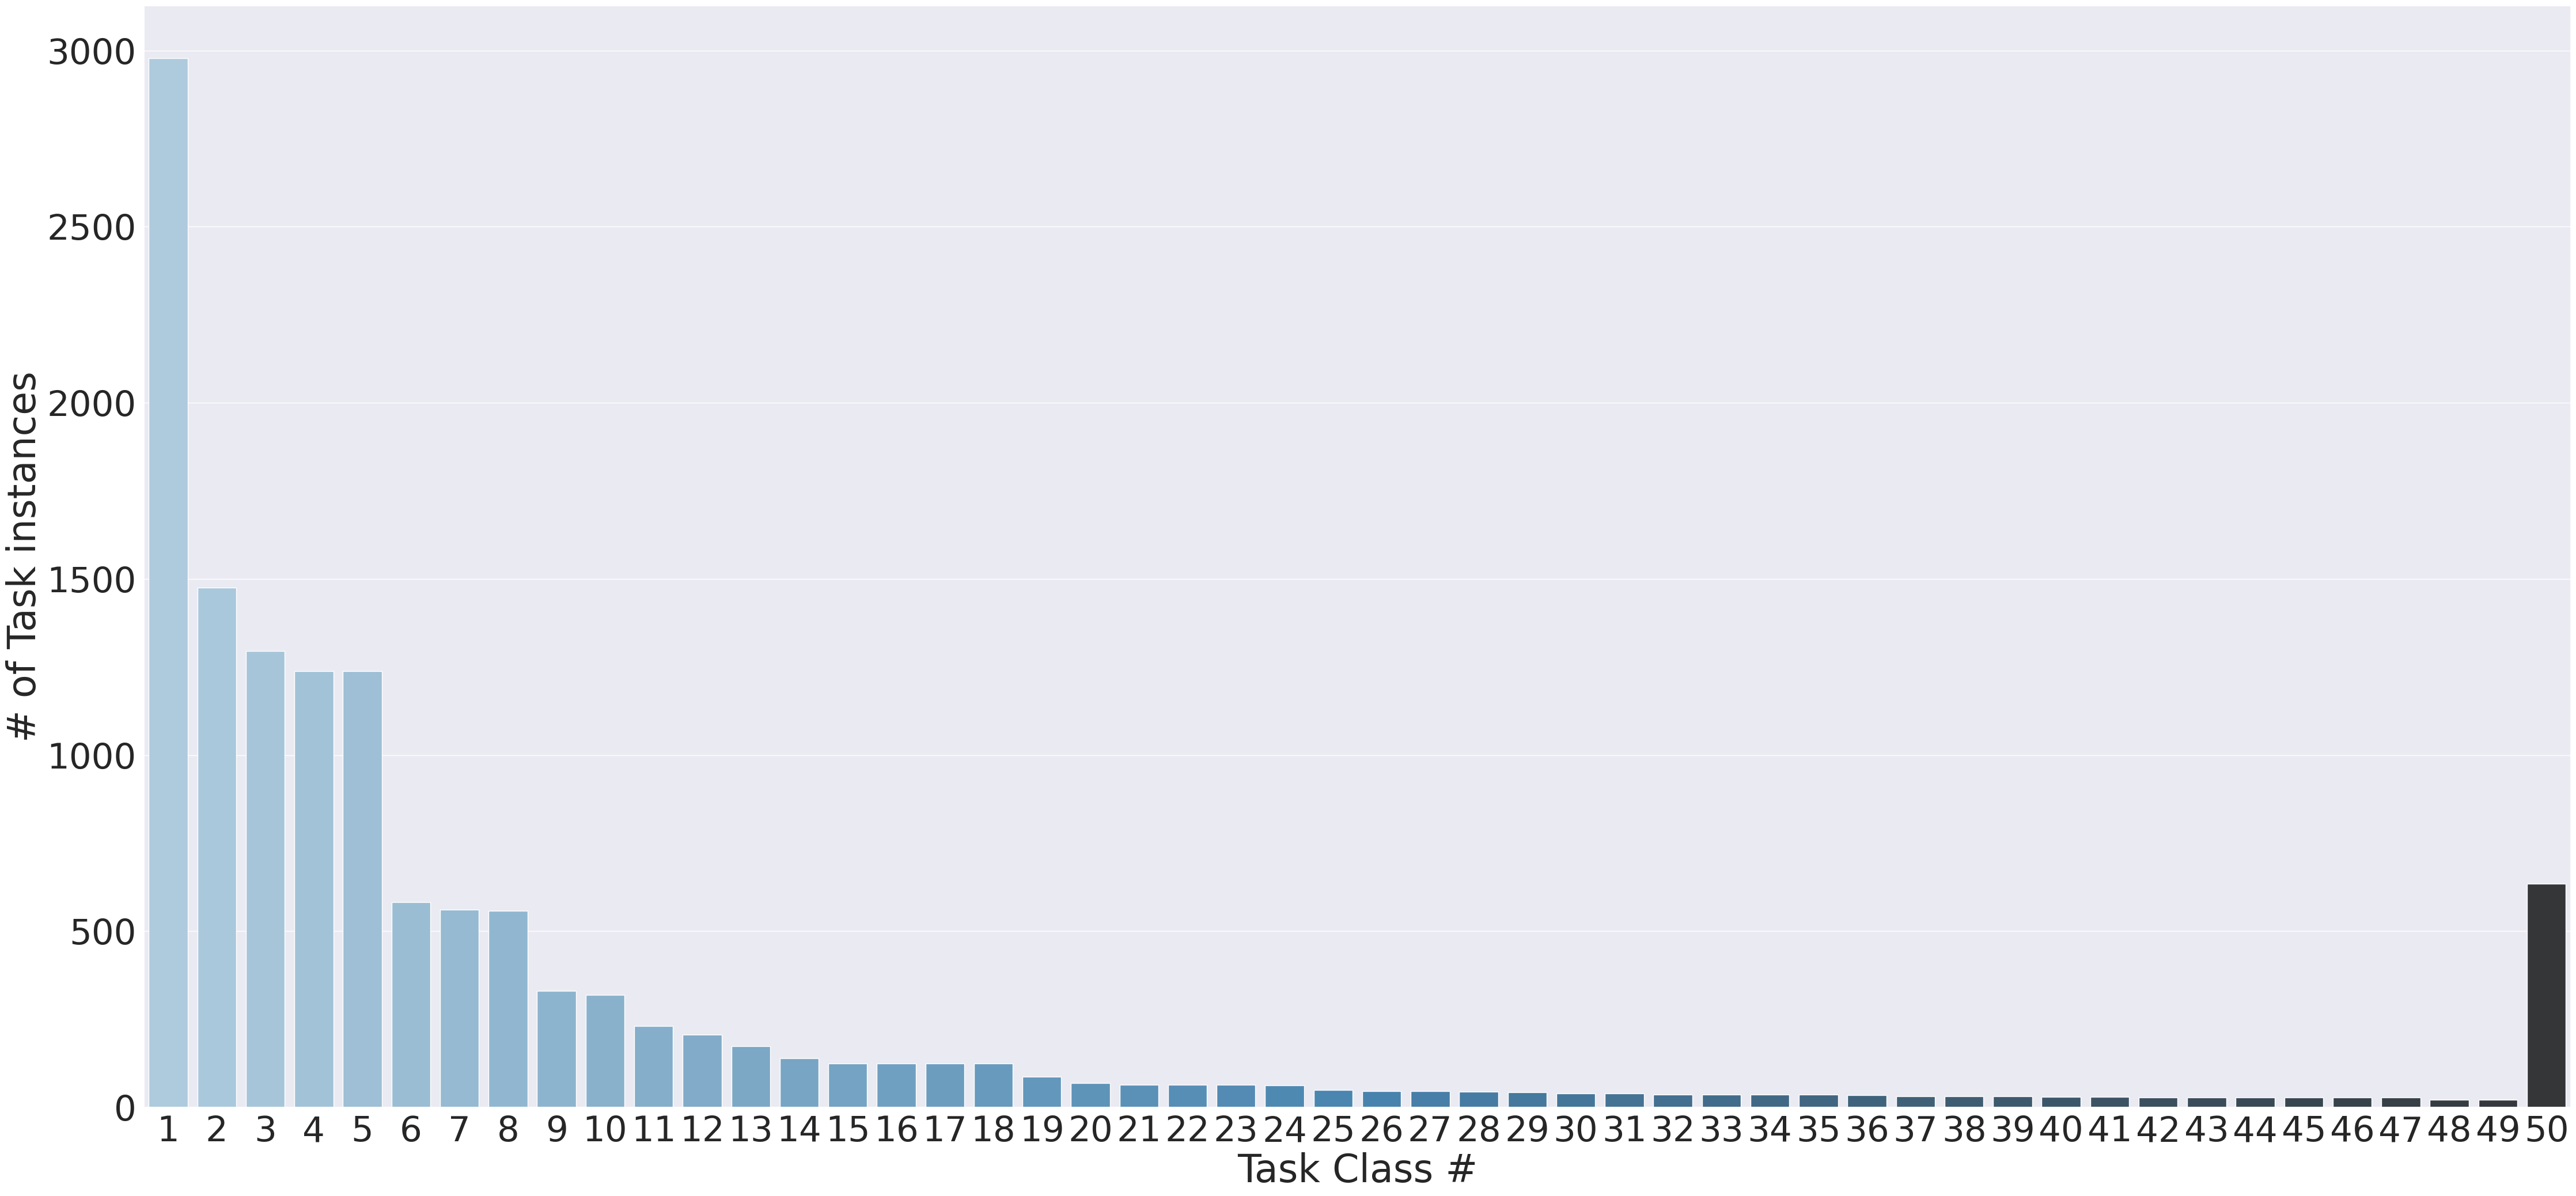

In [85]:
sns.set(style="darkgrid", font_scale=4)

fig = plt.figure(figsize=(46, 22))
sns.barplot(data=groupped_df_50, y='n_tasks', x='task_id', palette="Blues_d")
plt.xlabel('Task Class #')
plt.ylabel('# of Task instances')
fig.tight_layout()
fig.savefig(f'data/task-classes-distribution.pdf', bbox_inches='tight', dpi=plt.gcf().dpi)